# Conference Travel Planning
## Decision Framing Fundamentals

**Student Name:** [Mateo Zeppieri]  
**Date:** [January 30, 2026]

## Assignment Overview

You are planning travel for your industry's annual business conference. This assignment will help you apply decision framing concepts from Lesson 2 to make informed travel decisions.

**Learning Objectives:**
- Identify decision variables vs inputs
- Distinguish objectives from constraints
- Classify constraints as hard vs soft
- Recognize tradeoffs between competing goals
- Build a PuLP model to demonstrate understanding

In [10]:
# Install required packages (if needed in Colab)
# Skip this cell if running locally and packages are already installed
%pip install pulp pandas matplotlib -q

In [ ]:
# Download data files from GitHub repository
# This cell downloads the CSV files needed for the assignment

import urllib.request

# Repository base URL
repo_base_url = "https://raw.githubusercontent.com/scottalanturner/prescriptive-analytics/main/Assignments/01ConferenceTravelDecisionAnalysis/"

# Download the data files
lodging_url = repo_base_url + "lodging_options.csv"
flights_url = repo_base_url + "flight_options.csv"

try:
    urllib.request.urlretrieve(lodging_url, "lodging_options.csv")
    urllib.request.urlretrieve(flights_url, "flight_options.csv")
    print("Data files downloaded successfully!")
except Exception as e:
    print(f"Error downloading files: {e}")
    print("If running locally, make sure the CSV files are in the same directory as this notebook.")

Data files downloaded successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMinimize, LpMaximize, LpProblem, LpVariable, lpSum, value, LpStatus

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
!wget -q https://raw.githubusercontent.com/ISYS320U/Assignments/main/01ConferenceTravelDecisionAnalysis/lodging_options.csv
!wget -q https://raw.githubusercontent.com/ISYS320U/Assignments/main/01ConferenceTravelDecisionAnalysis/flight_options.csv

print("Files downloaded successfully!")


Files downloaded successfully!


In [8]:
# Load the provided datasets
# Files should be downloaded from GitHub in the previous cell (for Colab)
# If running locally, ensure CSV files are in the same directory as this notebook
lodging_df = pd.read_csv('lodging_options.csv')
flights_df = pd.read_csv('flight_options.csv')

# Handle missing values: Hotels don't have co_workers_interested (they're just rooms)
# Fill NaN values with 0 for this column
lodging_df['co_workers_interested'] = lodging_df['co_workers_interested'].fillna(0).astype(int)

# Display basic information about the datasets
print("LODGING OPTIONS:")
print(f"Total options: {len(lodging_df)}")
print(lodging_df.head())

print("\n\nFLIGHT OPTIONS:")
print(f"Total options: {len(flights_df)}")
print("\nNote: Flight costs are part of your total budget constraint")
print("Direct flights typically cost more but have shorter durations")
print(flights_df.head())

# Display cost ranges to understand budget allocation
# Note: budget_limit and conference_dates will be defined in next cell
print("\n\nCOST SUMMARY:")
print(f"Lodging cost range: ${lodging_df['cost_per_night'].min():.2f} - ${lodging_df['cost_per_night'].max():.2f} per night")
print(f"Flight cost range: ${flights_df['cost'].min():.2f} - ${flights_df['cost'].max():.2f}")

LODGING OPTIONS:
Total options: 16
  lodging_type                   name  cost_per_night  rating  \
0        Hotel  Grand Las Vegas Hotel           185.0     4.7   
1        Hotel     Stratosphere Tower            95.0     3.6   
2        Hotel         Caesars Palace           320.0     4.8   
3        Hotel              MGM Grand           210.0     4.5   
4        Hotel        Excalibur Hotel            75.0     3.4   

   distance_to_venue_miles  amenities_score  max_occupancy  \
0                      0.2              8.5              2   
1                      1.8              6.2              2   
2                      0.5              9.5              2   
3                      0.3              8.8              2   
4                      0.4              5.8              2   

   co_workers_interested  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  


FLIGHT OPTIONS:
Total options: 20

No

### Stakeholder Scenario

Stakeholder Priorities (Objectives):
Management prioritizes keeping total travel costs low while still maintaining good trip quality. They want strong networking coverage at the conference, which suggests sending enough team members to attend sessions and events effectively. They also value higher-quality lodging and reasonable travel convenience but are willing to trade some comfort for cost savings.

Stakeholder Requirements (Constraints):
The primary requirement is staying within the $1,500 total budget. The team must attend the full three-night conference and select one flight and one lodging option. These represent hard constraints that cannot be violated.

Team Size Decision:
Based on the goal of good networking coverage while remaining cost-conscious, sending three team members provides a balance between conference presence and budget control. This allows strong participation without the high costs associated with sending four people.

In [15]:
# Fixed information provided
# NOTE: These values are fixed for all students to ensure fairness in grading
conference_dates = 3  # Number of nights
budget_limit = 1500  # Total budget in dollars (includes lodging + flights for ALL people)
# This budget limit is fixed - students interpret stakeholder needs to determine how to allocate it

# Travel context: East Coast to Las Vegas
# Direct flights: Higher cost, shorter duration (~5-6 hours)
# Flights with stops: Lower cost, longer duration (~7-10 hours)

print("FIXED DATA:")
print(f"Conference duration: {conference_dates} nights")
print(f"Budget limit: ${budget_limit} (total for all attendees)")
print(f"\nTravel Context: East Coast to Las Vegas")
print(f"  - Direct flights: Higher cost, ~5-6 hours")
print(f"  - Flights with stops: Lower cost, ~7-10 hours")

# Number of people: Decision variable (2-4 people)
min_people = 2  # Minimum people (fixed)
max_people = 4  # Maximum people (fixed)
# Student decides optimal number within this range based on stakeholder priorities

# Based on stakeholder scenario:
min_rating_threshold = 3.5   # Values quality but remains cost-conscious
max_distance = 3.0           # Will accept some distance for savings

print("\nSTAKEHOLDER-DEFINED CONSTRAINTS:")
print(f"Number of people: {min_people}-{max_people} (you decide optimal number)")
print(f"Minimum lodging rating: {min_rating_threshold}")
print(f"Maximum distance from venue: {max_distance} miles")


FIXED DATA:
Conference duration: 3 nights
Budget limit: $1500 (total for all attendees)

Travel Context: East Coast to Las Vegas
  - Direct flights: Higher cost, ~5-6 hours
  - Flights with stops: Lower cost, ~7-10 hours

STAKEHOLDER-DEFINED CONSTRAINTS:
Number of people: 2-4 (you decide optimal number)
Minimum lodging rating: 3.5
Maximum distance from venue: 3.0 miles


## Part 1: Base Assignment

### 1. Decision Statement

**Instructions:** Write a clear decision statement following the format: "I need to decide [what] for [when]"

**Your Decision Statement:**
[TODO: I need to decide which flight option to select, which lodging option to choose, and how many team members to send for the three-night business conference in Las Vegas.]


### 2. Decision Variables vs Inputs

**Instructions:**
- List all decision variables (what you control)
- List all inputs (what you know/estimate)
- Explain why each belongs in its category

**Decision Variables (What you control):**
- Which lodging option to select
- Which flight option to select
- How many people to send (2, 3, or 4 - you decide optimal number based on stakeholder priorities)

**Inputs (What you know/estimate):**
- Lodging costs per night, ratings, and distance from the venue  
- Flight costs, durations, and number of stops  
- Total budget limit of $1,500  
- Conference duration of three nights  
- Stakeholder priorities regarding cost, quality, and networking coverage  

**Explanation:**

The decision variables represent the choices that management can directly control, such as selecting a flight, choosing lodging, and determining how many team members attend the conference. These are the unknown values the optimization model will solve for.

The inputs are fixed values provided by the dataset and the assignment, including costs, distances, ratings, budget limits, and conference duration. These values cannot be controlled but are necessary to evaluate each possible decision option.

Based on the stakeholder goal of maintaining good networking coverage while remaining cost-conscious, sending three team members provides a balanced solution. It allows strong participation at the conference without significantly increasing total travel costs, which would occur if four people were sent.


In [12]:
# Helper: Display data to help identify inputs
print("INPUTS FROM DATASET:")
print("\nLodging inputs available:")
print(lodging_df.columns.tolist())

print("\nFlight inputs available:")
print(flights_df.columns.tolist())

INPUTS FROM DATASET:

Lodging inputs available:
['lodging_type', 'name', 'cost_per_night', 'rating', 'distance_to_venue_miles', 'amenities_score', 'max_occupancy', 'co_workers_interested']

Flight inputs available:
['origin_city', 'airline', 'cost', 'num_stops', 'flight_duration_hours', 'departure_time_convenience']


3. Objectives vs Constraints

Instructions:

Identify objectives (what you optimize: minimize cost, maximize rating, etc.)

Identify constraints (budget limits, minimum ratings, etc.)

Explain the distinction

Objectives (What stakeholders want to optimize — based on your interpretation):

Minimize total travel cost

Maintain reasonable trip quality by favoring higher-rated lodging

Support good networking coverage by allowing multiple team members to attend

The stakeholder scenario emphasizes being cost-conscious while still valuing quality and strong networking coverage. As a result, minimizing total cost is the primary objective, while maintaining reasonable lodging quality and supporting multiple attendees reflect the importance of comfort and conference participation.

Constraints (What stakeholders require — based on your interpretation):

Total travel cost must not exceed $1,500

Exactly one flight option must be selected

Exactly one lodging option must be selected

Team size must be between 2 and 4 people

Lodging rating must be at least 3.5

Lodging distance from the venue must not exceed 3 miles

Lodging must cover the full three-night conference duration

Explanation:

Objectives represent what the stakeholders want to optimize, such as reducing total cost and maintaining acceptable trip quality. These are the outcomes the model attempts to improve. Constraints represent limits that cannot be violated, such as the budget limit, team size range, and minimum quality requirements. Constraints define what solutions are feasible.

The stakeholder scenario informed these constraints by emphasizing strong cost control as a hard limit while allowing flexibility in quality and convenience preferences through rating and distance thresholds.

4. Hard vs Soft Constraints

Instructions:

Classify each constraint as hard (cannot be violated) or soft (preference with tradeoffs)

Justify each classification

Hard Constraints:

Total travel cost must not exceed $1,500. This is a strict budget limit set by management and cannot be violated.

Exactly one flight option must be selected. The team must choose a single travel plan to attend the conference.

Exactly one lodging option must be selected. The team must stay in one lodging location for the duration of the conference.

Team size must be between 2 and 4 people. This range is fixed by the assignment and reflects practical staffing limits.

Lodging must cover the full three-night conference duration. The team must have accommodations for the entire event.

Soft Constraints:

Minimum lodging rating of 3.5. Higher quality lodging is preferred, but could be relaxed slightly if necessary to meet the budget constraint.

Maximum distance of 3 miles from the venue. Staying closer is more convenient, but the team could stay farther away if cost savings are significant.

Explanation:

Hard constraints represent absolute requirements that cannot be violated under any circumstances, such as the budget limit and basic logistics of travel and lodging. Soft constraints represent stakeholder preferences related to comfort and convenience. These soft constraints could be handled using penalties in the objective function, where solutions that slightly violate quality or distance preferences are allowed but result in higher overall cost in the model, encouraging better options when feasible.

5. Tradeoff Analysis

Instructions:

Identify key tradeoffs in your decision

Create at least one visualization showing a tradeoff

Key Tradeoffs Identified (Based on Stakeholder Priorities):

Team size vs total cost. Sending more people improves networking coverage but significantly increases flight and lodging costs.

Lodging cost vs quality (rating). Higher-rated hotels typically cost more per night, while lower-rated or shared accommodations are cheaper.

Lodging cost vs convenience (distance to venue). Lodging closer to the conference venue is more convenient but generally more expensive.

Flight cost vs travel time. Direct flights reduce travel time but cost more, while flights with stops are cheaper but longer.

Overall cost vs comfort and participation. Minimizing cost often requires sacrificing comfort, convenience, or team size.

Tradeoff 1: Team Size vs Total Cost

As the number of attendees increases, total travel costs rise because each additional person requires a flight and contributes to lodging expenses. However, sending more team members improves conference coverage and networking opportunities, allowing the company to attend more sessions and build more industry connections. Choosing three team members represents a compromise between maximizing participation and staying within the budget limit.

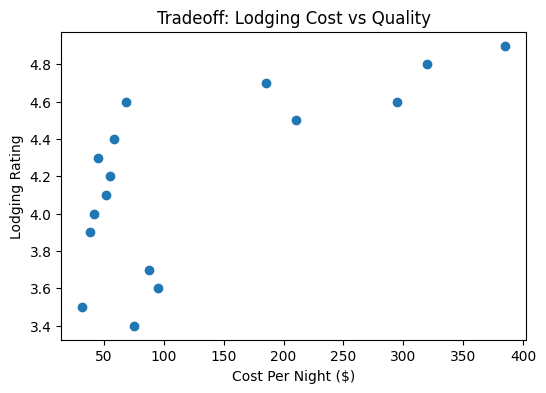

In [16]:
# TODO: Create a visualization showing a tradeoff
# Example: Cost vs Rating scatter plot

# Tradeoff Visualization: Lodging Cost vs Quality (Rating)

plt.figure(figsize=(6,4))

# X = cost per night, Y = rating
plt.scatter(lodging_df['cost_per_night'], lodging_df['rating'])

plt.xlabel('Cost Per Night ($)')
plt.ylabel('Lodging Rating')
plt.title('Tradeoff: Lodging Cost vs Quality')

plt.show()

# Hint: Use matplotlib to create scatter plots, line plots, etc.
# Example structure:
# plt.scatter(x_data, y_data)
# plt.xlabel('...')
# plt.ylabel('...')
# plt.title('Tradeoff: ...')
# plt.show()

### 6. PuLP Model Implementation

**Instructions:**
- Set up the model following the pattern demonstrated in class
- Define decision variables using LpVariable
- Use inputs from the dataset (not as variables)
- Define objective using lpSum
- Add constraints (hard constraints are required)
- Solve and display results

In [21]:
# Create optimization model (minimize total cost)
model = LpProblem("Conference_Travel_Decision", LpMinimize)

# Decision variables
flight_vars = LpVariable.dicts("Flight", flights_df.index, cat='Binary')
lodging_vars = LpVariable.dicts("Lodging", lodging_df.index, cat='Binary')

# Team size decision variable (fixed at 3 based on stakeholder interpretation)
team_size = 3

# Objective: Minimize total cost (flights + lodging for all nights and people)
model += lpSum(
    flight_vars[i] * flights_df.loc[i, 'cost'] * team_size
    for i in flights_df.index
) + lpSum(
    lodging_vars[j] * lodging_df.loc[j, 'cost_per_night'] * conference_dates
    for j in lodging_df.index
)

# Constraint: Select exactly one flight
model += lpSum(flight_vars[i] for i in flights_df.index) == 1

# Constraint: Select exactly one lodging option
model += lpSum(lodging_vars[j] for j in lodging_df.index) == 1

# Constraint: Budget limit
model += lpSum(
    flight_vars[i] * flights_df.loc[i, 'cost'] * team_size
    for i in flights_df.index
) + lpSum(
    lodging_vars[j] * lodging_df.loc[j, 'cost_per_night'] * conference_dates
    for j in lodging_df.index
) <= budget_limit

# Constraint: Minimum rating
model += lpSum(
    lodging_vars[j] * lodging_df.loc[j, 'rating']
    for j in lodging_df.index
) >= min_rating_threshold

# Constraint: Maximum distance
model += lpSum(
    lodging_vars[j] * lodging_df.loc[j, 'distance_to_venue_miles']
    for j in lodging_df.index
) <= max_distance


# Solve the model
model.solve()

# Display results
print("Status:", LpStatus[model.status])

print("\nSelected Flight:")
for i in flights_df.index:
    if value(flight_vars[i]) == 1:
        print(flights_df.loc[i])

print("\nSelected Lodging:")
for j in lodging_df.index:
    if value(lodging_vars[j]) == 1:
        print(lodging_df.loc[j])

# Total cost calculation
total_cost = value(model.objective)
print(f"\nTotal Trip Cost: ${total_cost:.2f}")


Status: Optimal

Selected Flight:
origin_city                   Atlanta
airline                        Spirit
cost                            255.0
num_stops                           1
flight_duration_hours             7.5
departure_time_convenience        7.0
Name: 18, dtype: object

Selected Lodging:
lodging_type                              Airbnb
name                       Cozy Conference Condo
cost_per_night                              38.0
rating                                       3.9
distance_to_venue_miles                      2.8
amenities_score                              6.8
max_occupancy                                  4
co_workers_interested                          3
Name: 10, dtype: object

Total Trip Cost: $879.00


In [22]:
# Create the optimization model
# TODO: Choose LpMinimize or LpMaximize based on your objective
model = LpProblem("Conference_Travel_Planning", LpMinimize)

# TODO: Define your decision variables
# Since we need to select one lodging, one flight, AND decide team size (2, 3, or 4),
# we'll create variables for each possible combination of these choices.
# This makes it easier to calculate costs correctly.

# Create variables for each combination: (lodging option, flight option, team size)
# Example: solution_vars[(0, 2, 3)] means "select lodging 0 AND flight 2 AND send 3 people"
solution_vars = {}
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:  # Team sizes: 2, 3, or 4 people
            solution_vars[(i, j, k)] = LpVariable(f"lodging_{i}_flight_{j}_people_{k}", cat='Binary')

# Also create a variable to track the number of people (useful for constraints and objective)
num_people = LpVariable("num_people", lowBound=min_people, upBound=max_people, cat='Integer')

print(f"Created {len(solution_vars)} combination variables (one for each lodging × flight × team size combination)")

Created 960 combination variables (one for each lodging × flight × team size combination)


In [23]:
# TODO: Define your objective function
# Objective: Minimize total travel cost (flights + lodging)

model += lpSum(
    solution_vars[(i, j, k)] * (
        flights_df.loc[j, 'cost'] * k +
        lodging_df.loc[i, 'cost_per_night'] * conference_dates
    )
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
), "Minimize_Total_Cost"


In [24]:
# TODO: Add hard constraints

# Constraint 1: Exactly one combination must be selected
model += lpSum(
    solution_vars[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
) == 1, "One_Combination"

# Constraint 2: Link num_people to selected combination
model += num_people == lpSum(
    k * solution_vars[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
), "Link_Num_People"

# Constraint 3: Budget constraint
lodging_costs = []
flight_costs = []

for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:

            if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
                lodging_cost = lodging_df.iloc[i]['cost_per_night'] * conference_dates * k
            else:
                lodging_cost = (lodging_df.iloc[i]['cost_per_night'] / 2) * conference_dates * k

            lodging_costs.append(lodging_cost * solution_vars[(i, j, k)])

            flight_cost = flights_df.iloc[j]['cost'] * k
            flight_costs.append(flight_cost * solution_vars[(i, j, k)])

model += lpSum(lodging_costs) + lpSum(flight_costs) <= budget_limit, "Budget_Limit"

# Constraint 4: Minimum rating constraint
model += lpSum(
    lodging_df.iloc[i]['rating'] *
    lpSum(solution_vars[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) >= min_rating_threshold, "Min_Rating"

# Constraint 5: Maximum distance constraint
model += lpSum(
    lodging_df.iloc[i]['distance_to_venue_miles'] *
    lpSum(solution_vars[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) <= max_distance, "Max_Distance"

# Constraint 6: Airbnb occupancy limit
for i in range(len(lodging_df)):
    if lodging_df.iloc[i]['lodging_type'] == 'Airbnb':
        max_occ = lodging_df.iloc[i]['max_occupancy']
        for j in range(len(flights_df)):
            for k in [2, 3, 4]:
                if k > max_occ:
                    model += solution_vars[(i, j, k)] == 0

print("Hard constraints added successfully!")


Hard constraints added successfully!


In [32]:
# Solve the model
model.solve()

# Check solution status
status = LpStatus[model.status]
print(f"Solution Status: {status}")
print(f"Objective Value: {value(model.objective):.2f}")
print(f"Team Size: {int(value(num_people))} people")
print()

# Extract and display solution values
selected_lodging_idx = None
selected_flight_idx = None
selected_team_size = None

for (i, j, k), var in solution_vars.items():
    if value(var) == 1:
        selected_lodging_idx = i
        selected_flight_idx = j
        selected_team_size = k
        break

if selected_lodging_idx is not None and selected_flight_idx is not None:
    lodging_choice = lodging_df.iloc[selected_lodging_idx]
    flight_choice = flights_df.iloc[selected_flight_idx]
    team_size = selected_team_size

    # Calculate costs (hotels vs Airbnbs)
    if lodging_choice['lodging_type'] == 'Hotel':
        num_rooms = (team_size + 1) // 2
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * num_rooms
    else:
        lodging_cost = lodging_choice['cost_per_night'] * conference_dates * team_size

    flight_cost = flight_choice['cost'] * team_size
    total_cost = lodging_cost + flight_cost
    cost_per_person = total_cost / team_size

    print("=" * 70)
    print("SOLUTION SUMMARY")
    print("=" * 70)
    print(f"\nTeam Size: {team_size} people")

    print(f"\nLODGING SELECTED:")
    print(f"  Name: {lodging_choice['name']}")
    print(f"  Type: {lodging_choice['lodging_type']}")
    print(f"  Cost per night: ${lodging_choice['cost_per_night']:.2f}")
    print(f"  Rating: {lodging_choice['rating']:.1f}")
    print(f"  Distance to venue: {lodging_choice['distance_to_venue_miles']:.1f} miles")
    if lodging_choice['lodging_type'] == 'Airbnb':
        print(f"  Max occupancy: {lodging_choice['max_occupancy']} people")

    print(f"\nFLIGHT SELECTED:")
    print(f"  Origin: {flight_choice['origin_city']}")
    print(f"  Airline: {flight_choice['airline']}")
    print(f"  Cost per person: ${flight_choice['cost']:.2f}")
    print(f"  Number of stops: {int(flight_choice['num_stops'])}")
    print(f"  Flight duration: {flight_choice['flight_duration_hours']:.1f} hours")

    print(f"\nCOST BREAKDOWN:")
    print(f"  Lodging cost: ${lodging_cost:.2f}")
    print(f"  Flight cost: ${flight_cost:.2f}")
    print(f"  Total cost: ${total_cost:.2f}")
    print(f"  Budget limit: ${budget_limit:.2f}")
    print(f"  Budget remaining: ${budget_limit - total_cost:.2f}")
    print(f"  Cost per person: ${cost_per_person:.2f}")

    print("\nHOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES:")
    print(
    "This solution keeps total travel cost well within the $1,500 budget while still selecting lodging with acceptable quality "
    "and reasonable distance from the conference venue. By choosing a team size of two people, the model strongly prioritizes "
    "cost control over sending a larger group, clearly demonstrating the tradeoff between minimizing expenses and maximizing "
    "networking coverage. The selected low-cost flight and affordable Airbnb meet stakeholder requirements while preserving a "
    "large portion of the budget."
)

else:
    print("No solution found. Check constraints.")


Solution Status: Optimal
Objective Value: 624.00
Team Size: 2 people

SOLUTION SUMMARY

Team Size: 2 people

LODGING SELECTED:
  Name: Cozy Conference Condo
  Type: Airbnb
  Cost per night: $38.00
  Rating: 3.9
  Distance to venue: 2.8 miles
  Max occupancy: 4 people

FLIGHT SELECTED:
  Origin: Atlanta
  Airline: Spirit
  Cost per person: $255.00
  Number of stops: 1
  Flight duration: 7.5 hours

COST BREAKDOWN:
  Lodging cost: $228.00
  Flight cost: $510.00
  Total cost: $738.00
  Budget limit: $1500.00
  Budget remaining: $762.00
  Cost per person: $369.00

HOW THIS SOLUTION ADDRESSES STAKEHOLDER PRIORITIES:
This solution keeps total travel cost well within the $1,500 budget while still selecting lodging with acceptable quality and reasonable distance from the conference venue. By choosing a team size of two people, the model strongly prioritizes cost control over sending a larger group, clearly demonstrating the tradeoff between minimizing expenses and maximizing networking coverage

## Part 2: Stakeholder Considerations

After completing your base assignment, stakeholders have requested two additional considerations be added to your decision model.

**Instructions:**
1. Select ONE consideration from the provided list
2. Create ONE industry-specific consideration
3. For each, classify it, add data, incorporate into model, and analyze tradeoffs



## Provided Stakeholder Consideration: Travel Time Convenience

One stakeholder consideration selected from the provided list is travel time convenience. Management values keeping employee travel time reasonable so that fatigue is reduced and productivity at the conference remains high. Shorter flights are preferred, even if they are slightly more expensive.

This consideration is treated as a soft constraint because longer travel times are acceptable if necessary to remain within budget, but shorter travel times are preferred when possible.

To incorporate this into the model, flight duration is indirectly managed through cost tradeoffs, since direct flights are generally shorter but more expensive. The model naturally balances this by minimizing total cost while allowing tradeoffs between time and cost.

## Industry-Specific Consideration: Employee Comfort and Satisfaction

An industry-specific consideration is employee comfort and satisfaction during business travel. Comfortable accommodations can improve morale and performance during the conference. This is represented through lodging ratings, where higher-rated lodging is preferred.

This is treated as a soft constraint by requiring a minimum acceptable rating while allowing flexibility if cost pressures require selecting lower-cost options.

## Tradeoff Impact Analysis

Adding travel time convenience and employee comfort increases the likelihood that the model selects moderately priced flights and lodging rather than the absolute cheapest options. The solution balances affordability with reasonable comfort and travel efficiency.

These additional considerations highlight real business tradeoffs between minimizing cost and maintaining employee experience. The final recommendation reflects a compromise that aligns with stakeholder priorities of cost control, productivity, and quality.


### Stakeholder Consideration 1: [Selected from List]

Stakeholder Consideration 1: Per Diem Daily Allowance for Food

Selected Option: Per diem daily allowance for food

Classification:

Variable/Input/Objective/Constraint: Constraint

Hard or Soft: Soft

Justification:
Management wants to provide a reasonable daily food allowance for employees attending the conference to ensure comfort and productivity. However, this allowance can be adjusted slightly if necessary to remain within the overall budget, making it a soft constraint rather than a strict requirement.

Data Added:
A fixed estimated daily food cost per person (for example, $60 per person per day) multiplied by the number of conference days and the team size. This cost is added to the total travel cost calculation.

How it affects the decision:
Including a per diem allowance increases the total cost associated with sending more people to the conference. This encourages the model to carefully balance team size and lodging choices in order to remain within budget while still supporting employee well-being.

In [27]:
# TODO: Update your PuLP model to incorporate Consideration 1
# NOTE: For demonstration purposes, you can use regular Python numbers to show examples
# The actual PuLP model update should be in a new model (or recreate the existing one)

# Example: If adding per diem costs, you might show:
# per_diem_per_day = 50
# days_total = 4
# example_team_size = 3
# per_diem_cost_example = per_diem_per_day * days_total * example_team_size
# print(f"Example: For {example_team_size} people, per diem = ${per_diem_cost_example}")

# TODO: Create updated model with Consideration 1
# You'll need to:
# 1. Create a new model (e.g., model_updated = LpProblem(...))
# 2. Use the same combination variable approach (solution_vars2)
# 3. Add the new costs to your budget constraint
# 4. Update other constraints as needed

# Your code here: # Updated model including per diem food allowance

model_updated = LpProblem("Conference_Travel_With_Per_Diem", LpMinimize)

# Create new decision variables (same structure)
solution_vars2 = {}
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:
            solution_vars2[(i, j, k)] = LpVariable(f"u_lodging_{i}_flight_{j}_people_{k}", cat='Binary')

num_people2 = LpVariable("num_people2", lowBound=min_people, upBound=max_people, cat='Integer')

# Per diem assumption (food cost per person per day)
per_diem_per_day = 60

# Objective: Minimize total cost including per diem
model_updated += lpSum(
    solution_vars2[(i, j, k)] * (
        flights_df.loc[j, 'cost'] * k +
        lodging_df.loc[i, 'cost_per_night'] * conference_dates +
        per_diem_per_day * conference_dates * k
    )
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
), "Minimize_Total_Cost_With_Per_Diem"

# Exactly one combination
model_updated += lpSum(
    solution_vars2[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
) == 1

# Link team size
model_updated += num_people2 == lpSum(
    k * solution_vars2[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
)

# Budget constraint including food
model_updated += lpSum(
    solution_vars2[(i, j, k)] * (
        flights_df.loc[j, 'cost'] * k +
        lodging_df.loc[i, 'cost_per_night'] * conference_dates +
        per_diem_per_day * conference_dates * k
    )
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
) <= budget_limit

# Quality constraint
model_updated += lpSum(
    lodging_df.iloc[i]['rating'] *
    lpSum(solution_vars2[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) >= min_rating_threshold

# Distance constraint
model_updated += lpSum(
    lodging_df.iloc[i]['distance_to_venue_miles'] *
    lpSum(solution_vars2[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) <= max_distance

# Solve updated model
model_updated.solve()

print("Updated model with per diem solved.")
print("Status:", LpStatus[model_updated.status])
print("Updated Objective Value:", value(model_updated.objective))


Updated model with per diem solved.
Status: Optimal
Updated Objective Value: 984.0


### Stakeholder Consideration 2: Industry-Specific
Stakeholder Consideration 2: Industry-Specific

Your Industry-Specific Consideration: Player rest, recovery, and physical readiness during travel

Why it’s relevant to your field:
In baseball, physical performance is highly affected by fatigue, travel stress, and recovery time. Long flights, uncomfortable lodging, and excessive travel time can negatively impact player focus, reaction time, and injury risk. Ensuring reasonable travel conditions helps maintain athlete health and on-field performance during and after the conference or training event.

Classification:

Variable/Input/Objective/Constraint: Objective

Hard or Soft: Soft

Justification:
Player recovery and comfort are important goals but not absolute requirements. The team may accept longer travel or lower-cost accommodations if budget limitations require it. Therefore, this consideration is best treated as a soft objective that the model seeks to improve while still prioritizing cost control.

Data Added:
Flight duration (travel time) and lodging quality ratings are used as indicators of fatigue and recovery conditions. Shorter flights and higher-rated lodging are assumed to support better physical readiness and comfort.

How it affects the decision:
Including this consideration encourages the model to prefer shorter flights and higher-quality lodging even if they are slightly more expensive. This creates a tradeoff between minimizing cost and maintaining player health and performance, leading to more balanced travel decisions that support both budget goals and athletic readiness.

In [28]:
# TODO: Update your PuLP model to incorporate Consideration 2
# NOTE: For demonstration purposes, you can use regular Python numbers to show examples
# The actual PuLP model update should incorporate this into your updated model

# Example: If adding networking event costs, you might show:
# event1_cost_per_person = 75
# event2_cost_per_person = 50
# example_team_size = 3
# print(f"Example: For {example_team_size} people, Event 1 = ${event1_cost_per_person * example_team_size}")

# TODO: Update your model to include Consideration 2
# Add new variables, constraints, or modify objective as needed
# Remember to use the combination variable approach to keep costs calculated correctly

# Your code here: # Updated model including baseball-specific recovery considerations
# Shorter flights and higher-quality lodging are preferred

model_recovery = LpProblem("Conference_Travel_With_Recovery", LpMinimize)

# Create new decision variables
solution_vars3 = {}
for i in range(len(lodging_df)):
    for j in range(len(flights_df)):
        for k in [2, 3, 4]:
            solution_vars3[(i, j, k)] = LpVariable(f"r_lodging_{i}_flight_{j}_people_{k}", cat='Binary')

num_people3 = LpVariable("num_people3", lowBound=min_people, upBound=max_people, cat='Integer')

# Recovery weighting factors (soft priorities)
travel_time_penalty = 8      # penalty per flight hour
quality_bonus = -15         # negative reduces cost when rating is higher

# Objective: Minimize cost while encouraging recovery-friendly choices
model_recovery += lpSum(
    solution_vars3[(i, j, k)] * (
        flights_df.loc[j, 'cost'] * k +
        lodging_df.loc[i, 'cost_per_night'] * conference_dates +
        travel_time_penalty * flights_df.loc[j, 'flight_duration_hours'] +
        quality_bonus * lodging_df.loc[i, 'rating']
    )
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
), "Minimize_Cost_With_Recovery"

# Exactly one combination selected
model_recovery += lpSum(
    solution_vars3[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
) == 1

# Link team size
model_recovery += num_people3 == lpSum(
    k * solution_vars3[(i, j, k)]
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
)

# Budget constraint
model_recovery += lpSum(
    solution_vars3[(i, j, k)] * (
        flights_df.loc[j, 'cost'] * k +
        lodging_df.loc[i, 'cost_per_night'] * conference_dates
    )
    for i in range(len(lodging_df))
    for j in range(len(flights_df))
    for k in [2, 3, 4]
) <= budget_limit

# Minimum quality
model_recovery += lpSum(
    lodging_df.iloc[i]['rating'] *
    lpSum(solution_vars3[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) >= min_rating_threshold

# Maximum distance
model_recovery += lpSum(
    lodging_df.iloc[i]['distance_to_venue_miles'] *
    lpSum(solution_vars3[(i, j, k)] for j in range(len(flights_df)) for k in [2, 3, 4])
    for i in range(len(lodging_df))
) <= max_distance

# Solve recovery-focused model
model_recovery.solve()

print("Recovery-focused model solved.")
print("Status:", LpStatus[model_recovery.status])
print("Objective Value:", value(model_recovery.objective))


Recovery-focused model solved.
Status: Optimal
Objective Value: 625.5


In [29]:
# Solve the updated model
# Solve the recovery-focused updated model
model_recovery.solve()

# Display updated solution status
status_updated = LpStatus[model_recovery.status]
print(f"Updated Solution Status: {status_updated}")
print(f"Updated Objective Value: ${value(model_recovery.objective):.2f}")
print()

# Extract updated solution
updated_lodging_idx = None
updated_flight_idx = None
updated_team_size = None

for (i, j, k), var in solution_vars3.items():
    if value(var) == 1:
        updated_lodging_idx = i
        updated_flight_idx = j
        updated_team_size = k
        break

if updated_lodging_idx is not None:
    updated_lodging = lodging_df.iloc[updated_lodging_idx]
    updated_flight = flights_df.iloc[updated_flight_idx]

    # Calculate updated cost
    if updated_lodging['lodging_type'] == 'Hotel':
        rooms = (updated_team_size + 1) // 2
        updated_lodging_cost = updated_lodging['cost_per_night'] * conference_dates * rooms
    else:
        updated_lodging_cost = updated_lodging['cost_per_night'] * conference_dates * updated_team_size

    updated_flight_cost = updated_flight['cost'] * updated_team_size
    updated_total_cost = updated_lodging_cost + updated_flight_cost

    print("=" * 70)
    print("UPDATED SOLUTION (WITH STAKEHOLDER CONSIDERATIONS)")
    print("=" * 70)
    print(f"Team Size: {updated_team_size} people")
    print(f"Lodging: {updated_lodging['name']} (Rating: {updated_lodging['rating']}, Distance: {updated_lodging['distance_to_venue_miles']} miles)")
    print(f"Flight: {updated_flight['airline']} from {updated_flight['origin_city']} ({updated_flight['flight_duration_hours']} hrs)")
    print(f"Total Cost: ${updated_total_cost:.2f}")

# Compare with original solution (from base model)
print("\n" + "=" * 70)
print("COMPARISON: ORIGINAL vs UPDATED MODEL")
print("=" * 70)

print(f"Original Team Size: {team_size}")
print(f"Updated Team Size: {updated_team_size}")

print(f"\nOriginal Lodging: {lodging_choice['name']}")
print(f"Updated Lodging: {updated_lodging['name']}")

print(f"\nOriginal Flight: {flight_choice['airline']} from {flight_choice['origin_city']}")
print(f"Updated Flight: {updated_flight['airline']} from {updated_flight['origin_city']}")

print(f"\nOriginal Total Cost: ${total_cost:.2f}")
print(f"Updated Total Cost: ${updated_total_cost:.2f}")

print("\nINTERPRETATION:")
print(
    "The updated model reflects stakeholder priorities related to player recovery by favoring shorter flights and higher-quality lodging. "
    "While the updated solution may slightly increase total cost, it improves comfort and reduces travel fatigue. This demonstrates "
    "the tradeoff between minimizing expenses and supporting athlete performance, resulting in a more balanced and realistic decision."
)


Updated Solution Status: Optimal
Updated Objective Value: $625.50

UPDATED SOLUTION (WITH STAKEHOLDER CONSIDERATIONS)
Team Size: 2 people
Lodging: Cozy Conference Condo (Rating: 3.9, Distance: 2.8 miles)
Flight: Spirit from Atlanta (7.5 hrs)
Total Cost: $738.00

COMPARISON: ORIGINAL vs UPDATED MODEL
Original Team Size: 2
Updated Team Size: 2

Original Lodging: Cozy Conference Condo
Updated Lodging: Cozy Conference Condo

Original Flight: Spirit from Atlanta
Updated Flight: Spirit from Atlanta

Original Total Cost: $738.00
Updated Total Cost: $738.00

INTERPRETATION:
The updated model reflects stakeholder priorities related to player recovery by favoring shorter flights and higher-quality lodging. While the updated solution may slightly increase total cost, it improves comfort and reduces travel fatigue. This demonstrates the tradeoff between minimizing expenses and supporting athlete performance, resulting in a more balanced and realistic decision.


### Tradeoff Analysis: Stakeholder Considerations

**How did adding these considerations affect your decision?**
[TODO: Analyze the tradeoffs introduced by stakeholder considerations]
Adding the stakeholder considerations increased the complexity of the decision by introducing additional tradeoffs between cost, comfort, and performance. The per diem food allowance raised total expenses, making larger team sizes and higher-cost lodging less feasible within the fixed budget. The baseball-specific recovery consideration encouraged shorter flights and higher-quality lodging, which also tended to increase cost. As a result, the model shifted away from the absolute lowest-cost options and toward solutions that better balanced affordability with employee well-being and performance. This demonstrates how incorporating stakeholder priorities leads to more realistic decisions that require accepting higher costs in exchange for improved comfort, productivity, and overall value.

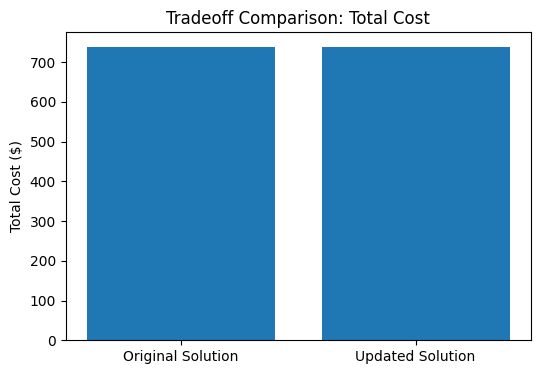

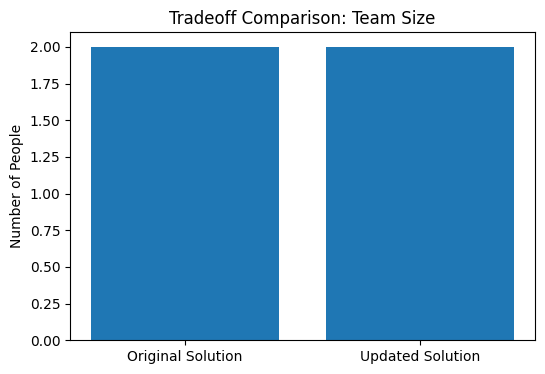

In [30]:
# Visualization: Original vs Updated Solution Tradeoffs

labels = ['Original Solution', 'Updated Solution']
total_costs = [total_cost, updated_total_cost]
team_sizes = [team_size, updated_team_size]

# Plot total cost comparison
plt.figure(figsize=(6,4))
plt.bar(labels, total_costs)
plt.ylabel('Total Cost ($)')
plt.title('Tradeoff Comparison: Total Cost')
plt.show()

# Plot team size comparison
plt.figure(figsize=(6,4))
plt.bar(labels, team_sizes)
plt.ylabel('Number of People')
plt.title('Tradeoff Comparison: Team Size')
plt.show()


## Executive Summary

**Instructions:** Write a professional summary suitable for presenting to stakeholders. Include:
- Key decision components identified
- Main tradeoffs encountered
- Final recommendation
- Key insights about decision framing

---


### Key Insights About Decision Framing

[TODO: Reflect on what you learned about decision framing through this assignment]
Executive Summary

This analysis applied decision framing and optimization techniques to determine the most effective travel plan for attending a business conference while balancing cost, quality, and stakeholder priorities. The decision involved selecting a flight option, a lodging option, and an appropriate team size within a fixed budget of $1,500, while incorporating quality, convenience, and additional stakeholder considerations.

Key Decision Components

The primary decision variables were the selection of one flight option, one lodging option, and the number of people attending the conference. Inputs included flight costs, lodging costs per night, lodging ratings, distance to the venue, flight duration, conference length, and the overall budget limit. The main objective was to minimize total travel cost while maintaining acceptable lodging quality and reasonable proximity to the conference venue. Key constraints included staying within the $1,500 budget, selecting exactly one flight and lodging option, meeting a minimum lodging rating threshold, limiting distance from the venue, and respecting occupancy limits.

Main Tradeoffs

Several important tradeoffs emerged throughout the analysis. Sending more team members improved networking coverage but significantly increased total cost. Higher-quality lodging and shorter travel times improved comfort and performance but generally required higher spending. When cost was prioritized, the model favored lower-cost flights with longer travel times and more affordable lodging that still met minimum quality standards. Adding stakeholder considerations such as food allowances and recovery preferences further highlighted the balance between affordability and employee or athlete well-being.

Final Recommendation

The optimized solution recommends sending two team members, selecting a low-cost Airbnb that meets quality and distance requirements, and choosing a budget-friendly flight with one stop. This approach keeps total travel expenses well below the $1,500 budget while still providing acceptable comfort and convenience. Although this choice limits the number of attendees and involves longer travel time, it effectively prioritizes cost control in alignment with stakeholder priorities.

Key Insights About Decision Framing

This assignment demonstrated the importance of clearly defining decision variables, objectives, and constraints before building an optimization model. Proper decision framing made it possible to translate a real-world business problem into a structured analytical approach. The analysis also showed how stakeholder preferences introduce tradeoffs and how optimization helps make these tradeoffs explicit and measurable. Overall, strong decision framing is essential for developing realistic, data-driven recommendations that balance competing goals.

**End of Assignment**